#### titanic 생존 예측 모델

-모델링 과정    
1. 다룰 데이터 원본 카피(원본 데이터 보존을 위함)
2. 데이터를 로드 & 분리 train과 test로
3. 탐색적 데이터 분석 (EDA)
4. 데이터 전처리
    - 결측치 처리
    - 전처리 : 인코딩 혹은 스케일링
5. 모델 수립 
6. 평가 r2_score, f1_score

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
test_df = pd.read_csv('./titanic/test.csv', encoding = 'utf-8')
train_df = pd.read_csv('./titanic/train.csv', encoding = 'utf-8')

In [3]:
# 데이터를 가공할 때 보통 원본은 건들지 않고 복사해서 가공
train_df_2 = train_df.copy()
test_df_2 = test_df.copy()

In [4]:
# 데이터프레임 확인
train_df_2.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
# 데이터 칼럼 결측치 타입 등 확인
train_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# 각 변수들의 검정통계량 확인
train_df_2.describe(include = 'all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [7]:
# 나중에 test에도 같은 과정을 적용시키기 위해 함수로 미리 만들어두기
def get_family(df):
    df['Family'] = df['SibSp'] + df['Parch'] + 1
    return df

get_family(train_df_2).head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1


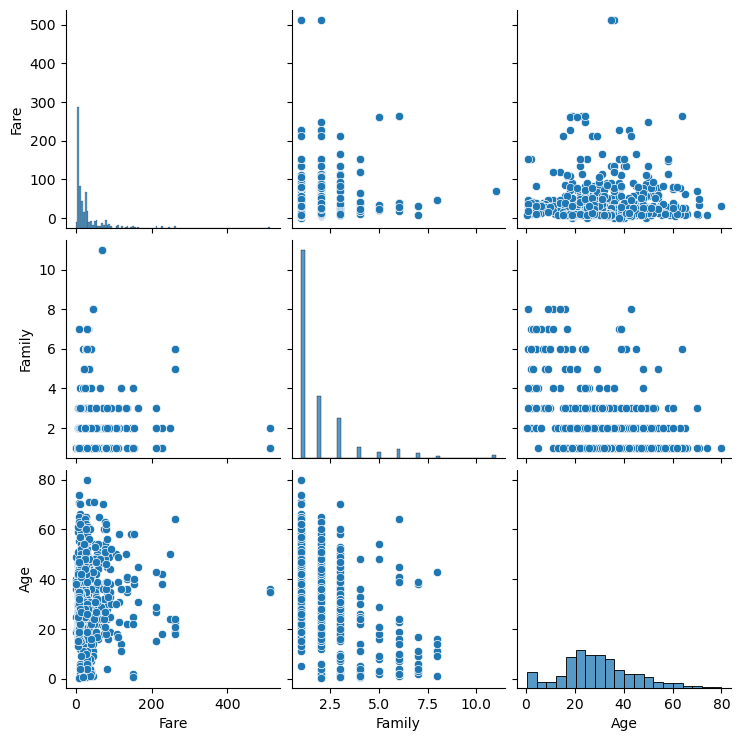

In [8]:
# 숫자형 변수들의 이상치 확인
sns.pairplot(train_df_2[['Fare','Family','Age']])

In [9]:
# 결측치 제거
train_df_2 = train_df_2[train_df_2['Fare'] < 512]

train_df_2.shape

(888, 13)

In [10]:
train_df_2['Fare'].describe()

count    888.000000
mean      30.582164
std       41.176366
min        0.000000
25%        7.895800
50%       14.454200
75%       30.771850
max      263.000000
Name: Fare, dtype: float64

In [72]:
# 결측치 처리(데이터 특성에 따라 결정)
def get_non_missing(df):
    Age_mean = df['Age'].mean()
    Fare_mean = df['Fare'].mean()
    
    df['Age'] = df['Age'].fillna(Age_mean)
    # Train 데이터에는 필요하지 않으나, test 데이터에 결측치가 존재해서 추가
    df['Fare'] = df['Fare'].fillna(Fare_mean)
    df['Embarked'] = df['Embarked'].fillna('S')
    return df

get_non_missing(train_df_2)

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,...,Embarked,Family,Fare_sd_sc,Age_mm_sc,Family_mm_Sc,Pclass_le,Sex_le,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,...,S,2,-0.566959,0.271174,0.1,2,1,0.0,0.0,1.0
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,...,C,2,0.989016,0.472229,0.1,0,0,1.0,0.0,0.0
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,...,S,1,-0.550557,0.321438,0.0,2,0,0.0,0.0,1.0
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,...,S,2,0.547171,0.434531,0.1,0,0,0.0,0.0,1.0
4,4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,...,S,1,-0.547519,0.434531,0.0,2,1,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,...,S,1,-0.427237,0.334004,0.0,1,1,0.0,0.0,1.0
884,887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,...,S,1,-0.014146,0.233476,0.0,0,0,0.0,0.0,1.0
885,888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.675345,1,2,W./C. 6607,...,S,4,-0.173308,0.367622,0.3,2,0,0.0,0.0,1.0
886,889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,...,C,1,-0.014146,0.321438,0.0,0,1,1.0,0.0,0.0


In [12]:
train_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  888 non-null    int64  
 1   Survived     888 non-null    int64  
 2   Pclass       888 non-null    int64  
 3   Name         888 non-null    object 
 4   Sex          888 non-null    object 
 5   Age          888 non-null    float64
 6   SibSp        888 non-null    int64  
 7   Parch        888 non-null    int64  
 8   Ticket       888 non-null    object 
 9   Fare         888 non-null    float64
 10  Cabin        202 non-null    object 
 11  Embarked     888 non-null    object 
 12  Family       888 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 97.1+ KB


In [57]:
def get_numeric_sc(df):
    # sd_sc : Fare / mm_sc : Age, Family
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    sd_sc = StandardScaler()
    mm_sc = MinMaxScaler()

    sd_sc.fit(df[['Fare']])
    df['Fare_sd_sc'] = sd_sc.transform(df[['Fare']])
    
    mm_sc.fit(df[['Age','Family']])
    df[['Age_mm_sc','Family_mm_sc']] = mm_sc.transform(df[['Age','Family']])


    return df

get_numeric_sc(train_df_2).describe()

,index,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Family,Fare_sd_sc,Age_mm_sc,Family_mm_Sc,Pclass_le,Sex_le,Embarked_C,Embarked_Q,Embarked_S
count,888.000000,888.000000,888.000000,888.000000,888.000000,888.000000,888.000000,888.000000,888.000000,8.880000e+02,888.000000,888.000000,888.000000,888.000000,888.000000,888.000000,888.000000
mean,444.618243,445.618243,0.381757,2.313063,29.675345,0.524775,0.381757,30.582164,1.906532,1.108973e-16,0.367622,0.090653,1.313063,0.647523,0.185811,0.086712,0.727477
std,257.405474,257.405474,0.486091,0.834007,13.019816,1.104186,0.806949,41.176366,1.615609,1.000564e+00,0.163607,0.161561,0.834007,0.478011,0.389173,0.281571,0.445508
min,0.000000,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000,-7.431301e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,221.750000,222.750000,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800,1.000000,-5.512664e-01,0.271174,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,444.500000,445.500000,0.000000,3.000000,29.675345,0.000000,0.000000,14.454200,1.000000,-3.919008e-01,0.367622,0.000000,2.000000,1.000000,0.000000,0.000000,1.000000
75%,666.250000,667.250000,1.000000,3.000000,35.000000,1.000000,0.000000,30.771850,2.000000,4.609266e-03,0.434531,0.100000,2.000000,1.000000,0.000000,0.000000,1.000000
max,890.000000,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,263.000000,11.000000,5.647628e+00,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
# 범주형
def get_category(df):
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
    le_p = LabelEncoder()
    le_s = LabelEncoder()
    oe = OneHotEncoder()
    
    le_p.fit(df[['Pclass']])
    df['Pclass_le'] = le_p.transform(df['Pclass'])
    
    le_s.fit(df[['Sex']])
    df['Sex_le'] = le_s.transform(df['Sex'])

    df = df.reset_index()
    oe.fit(df[['Embarked']])
    embarked_csr = oe.transform(df[['Embarked']])
    embarked_csr_df = pd.DataFrame(embarked_csr.toarray(), columns = oe.get_feature_names_out())
    df = pd.concat([df, embarked_csr_df], axis = 1)
    
    return df

train_df_2 = get_category(train_df_2)

c:\Users\and_c\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\and_c\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
train_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888 entries, 0 to 887
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         888 non-null    int64  
 1   PassengerId   888 non-null    int64  
 2   Survived      888 non-null    int64  
 3   Pclass        888 non-null    int64  
 4   Name          888 non-null    object 
 5   Sex           888 non-null    object 
 6   Age           888 non-null    float64
 7   SibSp         888 non-null    int64  
 8   Parch         888 non-null    int64  
 9   Ticket        888 non-null    object 
 10  Fare          888 non-null    float64
 11  Cabin         202 non-null    object 
 12  Embarked      888 non-null    object 
 13  Family        888 non-null    int64  
 14  Fare_sd_sc    888 non-null    float64
 15  Age_mm_sc     888 non-null    float64
 16  Family_mm_Sc  888 non-null    float64
 17  Pclass_le     888 non-null    int64  
 18  Sex_le        888 non-null    

In [85]:
# 선형회귀 함수 만들기
def get_model(df):
    from sklearn.linear_model import LogisticRegression
    model_lor = LogisticRegression()
    X = df[['Age_mm_sc','Fare_sd_sc','Family_mm_sc','Sex_le','Pclass_le','Embarked_C','Embarked_Q','Embarked_S']]
    y = df[['Survived']]
    return model_lor.fit(X,y)

    

In [86]:
model_output = get_model(train_df_2)
model_output

c:\Users\and_c\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [24]:
X = train_df_2[['Age_mm_sc','Fare_sd_sc','Family_mm_sc','Sex_le','Pclass_le','Embarked_C','Embarked_Q','Embarked_S']]
y_pred = model_output.predict(X)

In [26]:
# 평가
def evaluation_model(df) :
    from sklearn.metrics import accuracy_score, f1_score
    print(accuracy_score(df['Survived'],y_pred))
    print(f1_score(df['Survived'],y_pred))

In [27]:
evaluation_model(train_df_2)

0.8029279279279279
0.7320061255742726


# test 데이터에 적용하기

In [73]:
test_df_2 = test_df.copy()

In [77]:
# train하며 만든 함수 적용하기 전 똑같이 test 데이터 확인
test_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
 11  Family       418 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


In [31]:
# 지금까지 불러온 함수
function_list = [func for func in globals().values() if callable(func)]
print(function_list)

[<bound method InteractiveShell.get_ipython of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x000001EA7079D0A0>>, <IPython.core.autocall.ZMQExitAutocall object at 0x000001EA7079DD60>, <IPython.core.autocall.ZMQExitAutocall object at 0x000001EA7079DD60>, <function get_family at 0x000001EA7693FDC0>, <function get_non_missing at 0x000001EA778B3940>, <function get_numeric_sc at 0x000001EA7251E820>, <function get_category at 0x000001EA7251E790>, <function get_model at 0x000001EA781D2940>, <function accuracy_score at 0x000001EA77EBF670>, <function f1_score at 0x000001EA77EBFA60>, <function evaluation_model at 0x000001EA77DFEAF0>]


- get_family
- get_non_missing
- get_numeric_sc
- get_category
- get_model

In [74]:
test_df_2 = get_family(test_df_2)

In [75]:
test_df_2 = get_non_missing(test_df_2)

In [80]:
test_df_2 = get_numeric_sc(test_df_2)

In [81]:
test_df_2 = get_category(test_df_2)

c:\Users\and_c\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\and_c\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [84]:
test_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         418 non-null    int64  
 1   PassengerId   418 non-null    int64  
 2   Pclass        418 non-null    int64  
 3   Name          418 non-null    object 
 4   Sex           418 non-null    object 
 5   Age           418 non-null    float64
 6   SibSp         418 non-null    int64  
 7   Parch         418 non-null    int64  
 8   Ticket        418 non-null    object 
 9   Fare          418 non-null    float64
 10  Cabin         91 non-null     object 
 11  Embarked      418 non-null    object 
 12  Family        418 non-null    int64  
 13  Fare_sd_sc    418 non-null    float64
 14  Age_mm_sc     418 non-null    float64
 15  Family_mm_Sc  418 non-null    float64
 16  Pclass_le     418 non-null    int64  
 17  Sex_le        418 non-null    int32  
 18  Embarked_C    418 non-null    

In [92]:
# train에서 만든 모델을 활용
test_df_2_x = test_df_2[['Age_mm_sc','Fare_sd_sc','Family_mm_sc','Sex_le','Pclass_le','Embarked_C','Embarked_Q','Embarked_S']]
y_test_pred = model_output.predict(test_df_2_x)

In [89]:
evaluation_model(train_df_2)

0.8029279279279279
0.7320061255742726


In [96]:
sub_df = pd.read_csv('./titanic/gender_submission.csv')
sub_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [97]:
sub_df['Survived'] = y_test_pred

In [98]:
sub_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [99]:
# 데이터 저장하기
sub_df.to_csv('./result.csv', index = False)

K-fold 수행하기

In [109]:
from sklearn.model_selection import KFold
import numpy as np

kfold = KFold(n_splits=5)
score = []
x = train_df_2[['Age_mm_sc','Fare_sd_sc','Family_mm_Sc','Pclass_le','Sex_le','Embarked_C','Embarked_Q','Embarked_S']]
y = train_df_2['Survived']
for i, (train_index, test_index) in enumerate(kfold.split(x)):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score
    model_lor2 = LogisticRegression()
    model_lor2.fit(X_train, y_train)
    y_pred2 = model_lor2.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred2).round(3)
    print(i,'번째 교차검증 정확도는',accuracy)
    score.append(accuracy)
    
print('평균 정확도',np.mean(score))

0 번째 교차검증 정확도는 0.792
1 번째 교차검증 정확도는 0.803
2 번째 교차검증 정확도는 0.775
3 번째 교차검증 정확도는 0.774
4 번째 교차검증 정확도는 0.836
평균 정확도 0.796


GridSearch 적용

In [114]:
from sklearn.model_selection import GridSearchCV

params = { 'solver' : ['newton-cg','lbfgs','liblinear','sag','saga'],
          'max_iter' : [100,200]}
grid_lor = GridSearchCV(model_lor2, param_grid = params, scoring = 'accuracy', cv = 5)
grid_lor.fit(X_train, y_train)

print('최고의 하이퍼 파라미터', grid_lor.best_params_)
print('최고의 정확도', grid_lor.best_score_.round(3))

c:\Users\and_c\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\and_c\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\and_c\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\and_c\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\and_c\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


최고의 하이퍼 파라미터 {'max_iter': 100, 'solver': 'newton-cg'}
최고의 정확도 0.785
